# **Predict Kids Learning Ability with Game Data**
------------------------------------------
## W207 Final Project 
#### Instructor: Peter Grabowski
#### Team Members: Daniel Luo, Jade Chia-Chun Hou, Linda Yang, Skyler Roh


### **Problem Space**
-------------------------------------------------
We would want to learn how kids learn with the data gather from a kid game app.   
In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.
The data we have contains the result which is the label of the data. How much attempt they tried, and what's the total answer and correct answer, the time taken etc. 
For the train and test data, we would have the event id, game session timestamp, event data which give detail description of the event.

We would like to use some machine learning model to understand the factors that would help kids learn faster in the game and succsefully tackle the assesment. 


### **Object**
--------------------
The intent of this project is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt)

### **Load the Packages**
--------------------------

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import numpy as np

%matplotlib inline


### **Load the Data**
-------------------------------------------

In [2]:
%%time
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input/data-science-bowl-2019/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input/data-science-bowl-2019/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_train_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input/data-science-bowl-2019/train_labels.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_specs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input/data-science-bowl-2019/specs.csv', header=0, sep=',', quotechar='"')
df_sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input/data-science-bowl-2019/sample_submission.csv', header=0, sep=',', quotechar='"')


CPU times: user 1min, sys: 3.37 s, total: 1min 3s
Wall time: 1min 29s


### **Exploratory Data Analysis**
---

#### Understanding the Train Data


##### a. Sample train data

In [3]:
print("Sample train data (rows: %d, columns: %d)" %(df_train.shape[0], df_train.shape[1]))
df_train.head()

Sample train data (rows: 11341042, columns: 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


Clean up the train data by dropping the row where the installation_id never take any game

##### b. Clean up train data

In [0]:
keep_id = df_train[df_train.type == "Assessment"][['installation_id']].drop_duplicates()
df_train = pd.merge(df_train, keep_id, on="installation_id", how="inner")

In [5]:
print("Sample train data after clean up (rows: %d, columns: %d)" %(df_train.shape[0], df_train.shape[1]))
df_train.head()

Sample train data after clean up (rows: 8294138, columns: 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK


After cleaning the data, we could see that the event data is in json format which would need later feature extracting and flatten. 
In the training set, we have the full history of gameplay data.
To help understand the naming convention of the model, below are list of coumn name and its explannation:
 In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts.

*  **event_id** - *Randomly generated unique identifier for the event type. Maps to event_id column in specs table.*
*  **game_session** - *Randomly generated unique identifier grouping events within a single game or video play session.*
*  **timestamp** - *Client-generated datetime
event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.*
*  **installation_id** - *Randomly generated unique identifier grouping game sessions within a single installed application instance.
event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.* 
*  **event_code** - *Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.*
*  **game_time** - *Time in milliseconds since the start of the game session. Extracted from event_data.*
*  **title** - *Title of the game or video.*
*  **type** - *Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.*
*  **world** - *The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).*



##### c. Visualization

In [6]:
df_train.type.unique()

array(['Clip', 'Activity', 'Game', 'Assessment'], dtype=object)

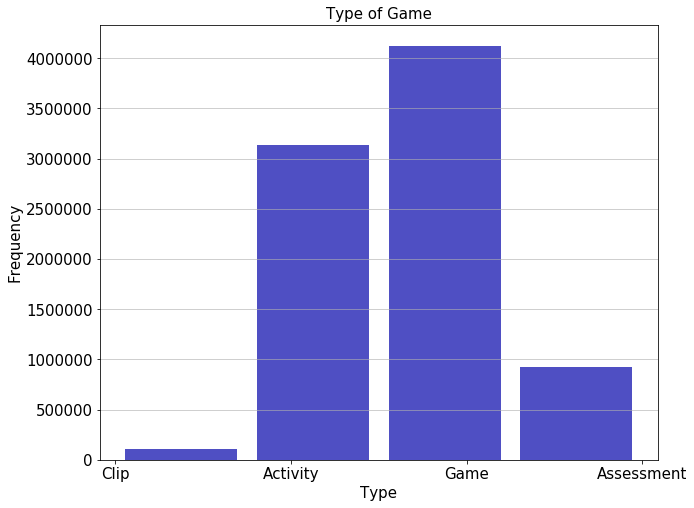

In [7]:
types_data = df_train['type']

plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=types_data, bins=4, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Type',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Type of Game',fontsize=15)
plt.show()

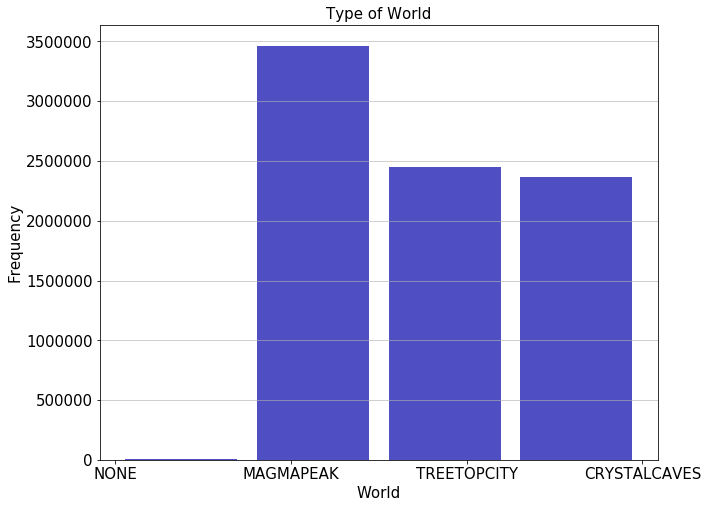

In [8]:
types_data = df_train['world']

plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=types_data, bins=4, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('World',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Type of World',fontsize=15)
plt.show()

Here we could see there are mainly three type of world in the game app. And the `Magmapeak` is very popular. 

In [0]:
title_frequency = df_train['title'].value_counts(sort=True, ascending=False)

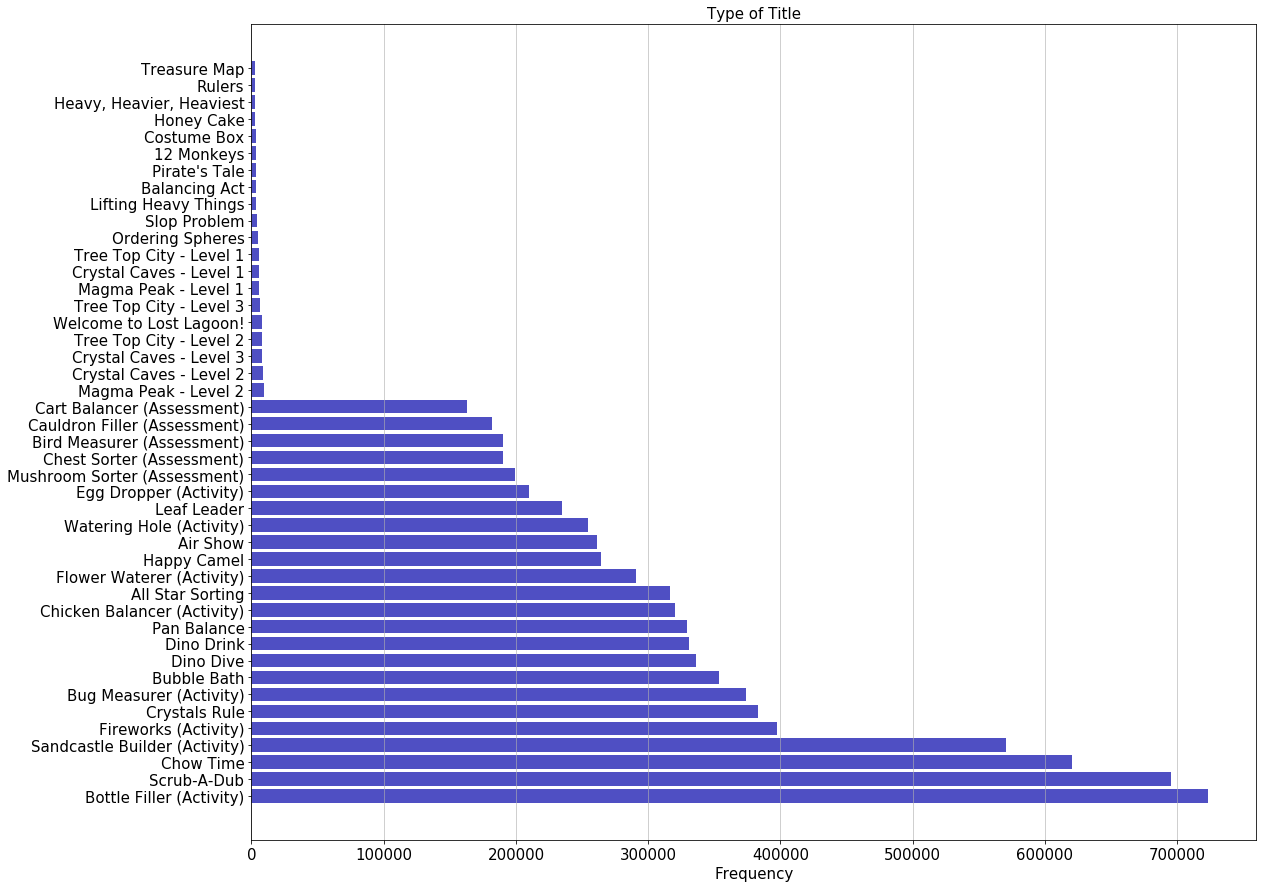

In [10]:
types_data = df_train['title']
plt.figure(figsize=[18,15])

frequencies = title_frequency.values
titles = title_frequency.keys().to_list()
y_pos = np.arange(len(titles))
plt.barh(y_pos, frequencies, color='#0504aa',alpha=0.7)
plt.yticks(y_pos, titles, fontsize=15)
plt.grid(axis='x', alpha=0.75)
plt.xlabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.title('Type of Title',fontsize=15)

plt.show()


Above is a histogram of the title of game appear in the data. We sort it the data, so that we could easily see the most frequent one is the Chow time, and `activity` type of game have more populartiy than `Assesment`. Interestingly, the level 1 and level 3 game have similar popularity. One guess would be, level 1 would be easier for kids to pass on, so they would only attempt once, level 2 are more chanllenging so they spend more time on it. As such, there will be less and less kid pass level 2, so level 3 also have lower frequency. 

#### Understand the Test Data

##### a. Sample test data and clean up test data

In [11]:
keep_id = df_test[df_test.type == "Assessment"][['installation_id']].drop_duplicates()
df_test = pd.merge(df_test, keep_id, on="installation_id", how="inner")
df_test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In the test set, it truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Every installation_id in the test set made an attempt on at least one assessment.

##### b. Visualization

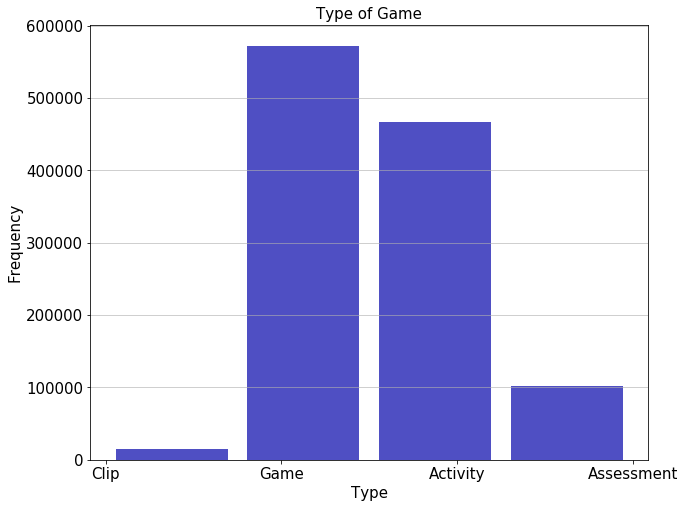

In [12]:
types_data = df_test['type']

plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=types_data, bins=4, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Type',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Type of Game',fontsize=15)
plt.show()

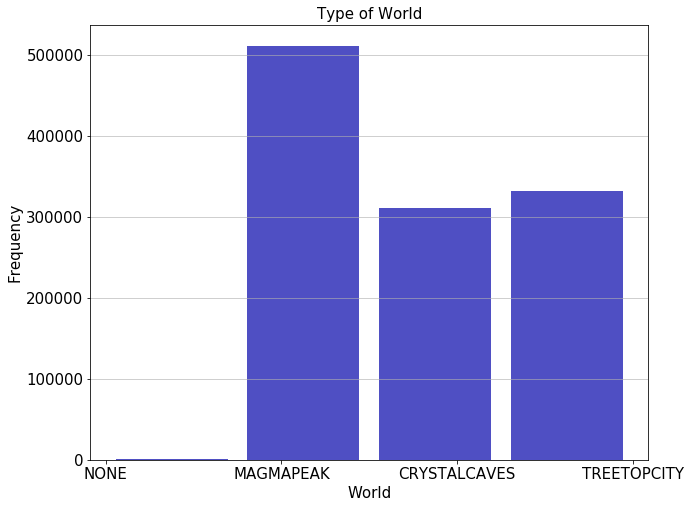

In [13]:
types_data = df_test['world']

plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=types_data, bins=4, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('World',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Type of World',fontsize=15)
plt.show()

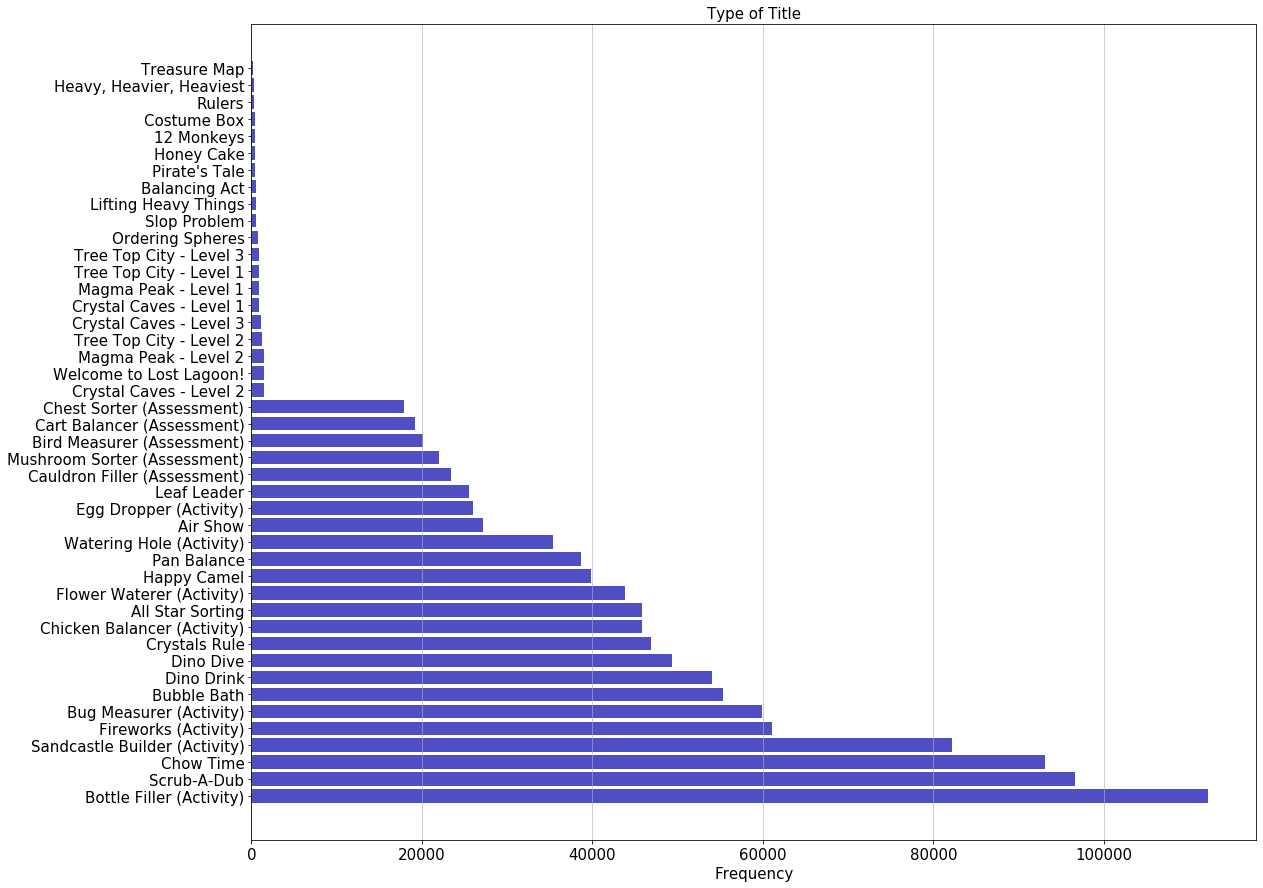

In [14]:
title_frequency = df_test['title'].value_counts(sort=True, ascending=False)
types_data = df_test['title']
plt.figure(figsize=[18,15])

frequencies = title_frequency.values
titles = title_frequency.keys().to_list()
y_pos = np.arange(len(titles))
plt.barh(y_pos, frequencies, color='#0504aa',alpha=0.7)
plt.yticks(y_pos, titles, fontsize=15)
plt.grid(axis='x', alpha=0.75)
plt.xlabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.title('Type of Title',fontsize=15)

plt.show()

We did the same visualization as we did for train data. We could see the trends does not change much. 

#### Understanding the Train Label data

##### a. Sample train label data

In [15]:
df_train_label.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


The outcomes in this data are grouped into 4 groups (labeled accuracy_group in the data):
3: the assessment was solved on the first attempt
2: the assessment was solved on the second attempt
1: the assessment was solved after 3 or more attempts
0: the assessment was never solved

Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

##### b. Visualization

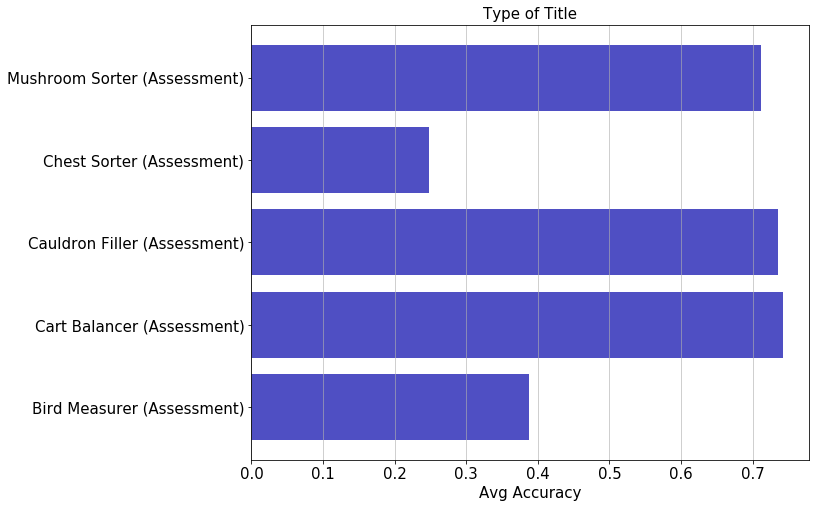

In [16]:
df_avg_accuracy = df_train_label.groupby('title').mean()
df_avg_accuracy.sort_values(by=['accuracy'])

avg_accuracy_data = df_avg_accuracy['accuracy']
plt.figure(figsize=[10,8])

titles = df_avg_accuracy.index
y_pos = np.arange(len(titles))
plt.barh(y_pos, avg_accuracy_data, color='#0504aa',alpha=0.7)
plt.yticks(y_pos, titles, fontsize=15)
plt.grid(axis='x', alpha=0.75)
plt.xlabel('Avg Accuracy',fontsize=15)
plt.xticks(fontsize=15)
plt.title('Type of Title',fontsize=15)

plt.show()

Here, we try to see the diffculty of each assesment we have. And how often does kid take this assesment. 

#### Understanding the spec data
This file gives the specification of the various event types.

*  **event_id** - *Global unique identifier for the event type. Joins to event_id column in events table.*
*  **info** - *Description of the event.*
*  **args** - *JSON formatted string of event arguments. Each argument contains:*
  *  **name** - *Argument name.*
  *  **type** - *Type of the argument (string, int, number, object, array).*
  *  **info** - *Description of the argument.*

### **Modeling**
---

##### a. Preprocessing data for models

We would like to merge label data and game data into one data set for training purpose. Here, we are getting the label data and merge them by game session.

In [32]:
# Select the training set with last game_session entries
train = df_train.drop_duplicates(subset = 'game_session', keep='last')
# Merge train and train_label datasets
train = pd.merge(train, df_train_label, on="game_session", how="inner")
print("The length after merging the training set and labels: ", len(train))

The length after merging the training set and labels:  17690


Sample new train data:

In [27]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id_x,event_count,event_code,game_time,title_x,type,world,installation_id_y,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,a5be6304,901acc108f55a5a1,2019-08-06T05:22:41.147Z,"{""session_duration"":39803,""exit_type"":""game_co...",0006a69f,48,2010,39803,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,e37a2b78,77b8ee947eb84b4e,2019-08-06T05:36:51.915Z,"{""description"":""Uh oh. This caterpillar is too...",0006a69f,87,3120,92799,Bird Measurer (Assessment),Assessment,TREETOPCITY,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,a5be6304,6bdf9623adc94d89,2019-08-06T05:38:16.835Z,"{""session_duration"":26827,""exit_type"":""game_co...",0006a69f,35,2010,26827,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,a5be6304,9501794defd84e4d,2019-08-06T20:35:25.648Z,"{""session_duration"":31843,""exit_type"":""game_co...",0006a69f,42,2010,31843,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,3393b68b,a9ef3ecb3d1acc6a,2019-08-06T20:50:35.426Z,"{""session_duration"":36368,""event_count"":32,""ga...",0006a69f,32,2010,36368,Bird Measurer (Assessment),Assessment,TREETOPCITY,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


Also for our baseline model, we only want to use the numerical/categoric features. So we choose event count,  and game time for our models.

##### b. SVM classifier


###### i. Import libraries

In [0]:
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

###### ii. Train model

In [0]:
# X -> features, y -> label 
random_train = train.sample(n = 1000) 
X = random_train.iloc[:,5:8]
y = random_train['accuracy_group']

In [34]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape (750, 3)
y_train.shape (750,)
X_test.shape: (250, 3)
y_test.shape: (250,)


In [0]:
# SVM model
clf = SVC()
svm_model = clf.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

In [36]:
# model accuracy for X_test   
accuracy = svm_model.score(X_test, y_test) 
print("SVM classifier's accuracy: ", accuracy)

SVM classifier's accuracy:  0.528


In [37]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 
print("SVM classifier's confusion_matrix:")
print(cm)

SVM classifier's confusion_matrix:
[[ 18   1   0  44]
 [ 24   0   0  16]
 [  6   0   0  21]
 [  6   0   0 114]]


##### c. Decision tree classifier


###### i. Import libraries


In [0]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

###### ii. Train model

In [0]:
# X -> features, y -> label 
random_train = train.sample(n = 5000) 
X = random_train.iloc[:,5:8]
y = random_train["accuracy_group"]

In [40]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape (3750, 3)
y_train.shape (3750,)
X_test.shape: (1250, 3)
y_test.shape: (1250,)


In [0]:
# training a Descision Tree Classifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

In [42]:
# accuracy on X_test 
accuracy = dtree_model.score(X_test, y_test) 
print("Decision tree classifier's accuracy: ", accuracy)

Decision tree classifier's accuracy:  0.7216


In [43]:
# creating a confusion matrix 
dtree_predictions = dtree_model.predict(X_test)  
cm = confusion_matrix(y_test, dtree_predictions) 
print("Decision tree classifier's confusion_matrix:")
cm

Decision tree classifier's confusion_matrix:


array([[285,   0,   0,   0],
       [ 31, 142,   0,   8],
       [ 18,  76,   0,  70],
       [ 66,  79,   0, 475]])

#### d. KNN (k-nearest neighbours) classifier 


###### i. Import libraries

In [0]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

###### ii. Train model

In [0]:
# X -> features, y -> label 
random_train = train.sample(n = 5000) 
X = random_train.iloc[:,5:8]
y = random_train["accuracy_group"]

In [46]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape (3750, 3)
y_train.shape (3750,)
X_test.shape: (1250, 3)
y_test.shape: (1250,)


In [0]:
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 

In [48]:
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print("KNN classifier's accuracy: ", accuracy)

KNN classifier's accuracy:  0.6912


In [49]:
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
print("KNN classifier's confusion_matrix:")
cm

KNN classifier's confusion_matrix:


array([[266,  13,   0,  19],
       [ 33,  83,  18,  35],
       [ 24,  29,  27,  91],
       [ 43,  40,  41, 488]])

### Feature Extraction

In [1]:
#%load_ext autoreload
#%autoreload 2
import features
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline


In [2]:
train, test, train_labels, specs = features.read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns


In [157]:
train.installation_id.unique().size

17000

In [158]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

In [159]:
train_labels.columns

Index(['game_session', 'installation_id', 'title', 'num_correct',
       'num_incorrect', 'accuracy', 'accuracy_group'],
      dtype='object')

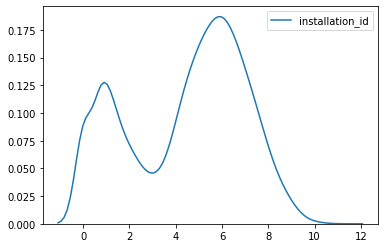

In [70]:
sns.kdeplot(np.log(train.installation_id.value_counts()))

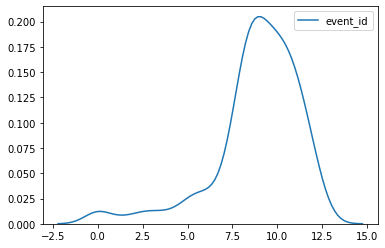

In [71]:
sns.kdeplot(np.log(train.event_id.value_counts()))

In [3]:
def get_worst_score(group):
    return group.sort_values('accuracy_group').iloc[0]

labels = train_labels.groupby(['installation_id', 'title']).apply(get_worst_score).reset_index(drop=True)

#### One installation example

In [64]:
train[(train.installation_id == '0006a69f')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
5334,832735e1,0721802df0531701,2019-08-29T16:33:53.227Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK
5335,ab3136ba,0721802df0531701,2019-08-29T16:33:56.880Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK
5336,832735e1,0721802df0531701,2019-08-29T16:34:11.881Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK
5337,ab3136ba,0721802df0531701,2019-08-29T16:34:15.480Z,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK


In [7]:
testing = train[(train.installation_id == '0006a69f')].merge(labels[labels.installation_id == '0006a69f'], on='installation_id')
groups = testing.groupby(['installation_id', 'game_session_y'])                                           
                                                             

In [8]:
groups

In [20]:
feats = groups \
        .apply(lambda x: features.summarize_events_before_game_session(x, game_session=x.name[1] if len(x.name) == 2 else '')) \
        .reset_index()

In [21]:
feats

,installation_id,game_session_y,event_count,game_time,num_unique_days,elapsed_days,last_world,last_game_session,type_counts,unique_game_sessions,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,0006a69f,77b8ee947eb84b4e,1230,1135,1,0,TREETOPCITY,77b8ee947eb84b4e,Activity 556 Game 525 Assessment...,26,Bird Measurer (Assessment),0,11,0.0,0
1,0006a69f,9501794defd84e4d,2201,3488,1,0,TREETOPCITY,9501794defd84e4d,Activity 1103 Game 845 Assessme...,48,Mushroom Sorter (Assessment),1,1,0.5,2


#### Run on all data

In [23]:
feats, labels = features.basic_user_features_transform(train, labels)

In [67]:
# Save checkpoint
feats.to_csv('installation_features.csv', index=False)
labels.to_csv('installation_labels.csv', index=False)

In [24]:
feats.shape

(9386, 10)

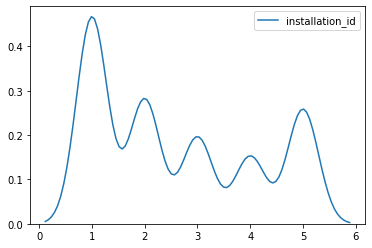

In [66]:
# installation ids have between 1 - 5 assessments in the training data
sns.kdeplot(labels.installation_id.value_counts())

In [33]:
feats.head()

,event_count,game_time,num_unique_days,elapsed_days,last_world,unique_game_sessions,activity_ct,game_ct,assessment_ct,clip_ct
0,1230,1135,1,0,TREETOPCITY,26,556.0,525.0,135.0,14.0
1,2201,3488,1,0,TREETOPCITY,48,1103.0,845.0,229.0,24.0
2,1566,1342,2,1,MAGMAPEAK,26,894.0,633.0,24.0,15.0
3,2222,2063,4,18,TREETOPCITY,48,1206.0,643.0,343.0,30.0
4,2014,1835,4,18,TREETOPCITY,44,1206.0,637.0,143.0,28.0


In [27]:
labels.head()

,title_y,num_correct,num_incorrect,accuracy,accuracy_group,installation_id,game_session_y
0,Bird Measurer (Assessment),0,11,0.0,0,0006a69f,77b8ee947eb84b4e
1,Mushroom Sorter (Assessment),1,1,0.5,2,0006a69f,9501794defd84e4d
2,Cauldron Filler (Assessment),1,0,1.0,3,0006c192,197a373a77101924
3,Bird Measurer (Assessment),1,1,0.5,2,0006c192,957406a905d59afd
4,Mushroom Sorter (Assessment),0,4,0.0,0,0006c192,b2297d292892745a


In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
import inspect

In [30]:
feature_pipe = features.get_data_processing_pipe(feats,log_features=['game_time', 'event_count'], categorical_features=['last_world'])

In [34]:
f = feature_pipe.fit_transform(feats[:1000])

In [37]:
f[0]

array([-0.58823969, -0.57109623, -0.14503066,  0.0607788 , -0.1039365 ,
       -0.16982723, -0.10627748,  0.12066108,  0.46398825,  0.        ,
        0.        ,  1.        ])

In [38]:
f[1]

array([-0.58823969, -0.57109623,  0.27396796,  0.74117096,  0.20558543,
        0.05003504,  0.22234801,  0.91260474,  0.95262231,  0.        ,
        0.        ,  1.        ])

In [ ]:
f[2]

In [49]:
lr_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', LogisticRegression())])

rf_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', RandomForestClassifier())])

In [46]:
lr_cv = GridSearchCV(lr_pipe, scoring='accuracy', param_grid={'clf__C': [10**i for i in range(-3, 4)], 'clf__max_iter': [1000]})
lr_cv.fit(feats, labels.accuracy_group)
pd.DataFrame(lr_cv.cv_results_)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                   

In [54]:
rf_cv = GridSearchCV(rf_pipe, scoring='accuracy', param_grid={'clf__max_depth': [1, 3, 5, 7, 9], 'clf__n_estimators': [100, 500, 1000]})
rf_cv.fit(feats, labels.accuracy_group)
pd.DataFrame(rf_cv.cv_results_)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                   

In [60]:
print(inspect.getsource(features))

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape

### Modeling with Extracted Features
---

import common libraries

In [0]:
# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

load the data

In [75]:
%%time
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input/installation_features.csv', header=0, sep=',', quotechar='"')


CPU times: user 26.5 ms, sys: 2.2 ms, total: 28.7 ms
Wall time: 1.21 s


sample the data

In [76]:
df.head()

,installation_id,game_session_y,event_count,game_time,num_unique_days,elapsed_days,last_world,last_game_session,unique_game_sessions,title_y,num_correct,num_incorrect,accuracy,accuracy_group,activity_ct,game_ct,assessment_ct,clip_ct
0,0006a69f,77b8ee947eb84b4e,1230,1135.912,1,0 days 00:00:00.000000000,TREETOPCITY,77b8ee947eb84b4e,26,Bird Measurer (Assessment),0,11,0.0,0,556.0,525.0,135.0,14.0
1,0006a69f,9501794defd84e4d,2201,3488.074,1,0 days 00:00:00.000000000,TREETOPCITY,9501794defd84e4d,48,Mushroom Sorter (Assessment),1,1,0.5,2,1103.0,845.0,229.0,24.0
2,0006c192,197a373a77101924,1566,1342.993,2,1 days 00:00:00.000000000,MAGMAPEAK,197a373a77101924,26,Cauldron Filler (Assessment),1,0,1.0,3,894.0,633.0,24.0,15.0
3,0006c192,957406a905d59afd,2222,2063.664,4,18 days 00:00:00.000000000,TREETOPCITY,957406a905d59afd,48,Bird Measurer (Assessment),1,1,0.5,2,1206.0,643.0,343.0,30.0
4,0006c192,b2297d292892745a,2014,1835.341,4,18 days 00:00:00.000000000,TREETOPCITY,b2297d292892745a,44,Mushroom Sorter (Assessment),0,4,0.0,0,1206.0,637.0,143.0,28.0


In [77]:
df.shape

(9386, 18)

#### a. Preprocessing data for models

In [78]:
# Split them into development and trainning dataset
features = ['game_time', 'unique_game_sessions', 'activity_ct', 'game_ct', 'assessment_ct', 'clip_ct']
X = df[features].to_numpy()
Y = df[['accuracy_group']].to_numpy().flatten()

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
# Convert NaN values to 0.
X = np.nan_to_num(X)

# Split into train and dev.
num_dev = int(len(Y)*0.1)
train_data, train_labels = X[num_dev:], Y[num_dev:]
dev_data, dev_labels = X[:num_dev], Y[:num_dev]

print ('Feature names:', features)
print('training label shape:', train_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', np.unique(Y))

Feature names: ['game_time', 'unique_game_sessions', 'activity_ct', 'game_ct', 'assessment_ct', 'clip_ct']
training label shape: (8448,)
dev label shape: (938,)
labels names: [0 1 2 3]


#### b. Logistic Regression

##### i. Import libraries

In [0]:
from sklearn.linear_model import LogisticRegression


##### ii. Train model

In [80]:
# Test different C values for Logistic Regression Model
candidate_c = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5,
               1, 5, 10, 50, 100, 1000]

best_f1 = -1
best_c = -1
for c in candidate_c:
  lr_model = LogisticRegression(penalty="l2",
                                C = c,
                                solver="liblinear",
                                multi_class="auto",
                                max_iter = 1000)
  lr_model.fit(train_data, train_labels)
  lr_predict_labels = lr_model.predict(dev_data)
  f1_score = metrics.f1_score(dev_labels, lr_predict_labels, average="weighted")
  for class_index in range(lr_model.coef_.shape[0]):
    squared_sum = np.sum(np.square(lr_model.coef_[class_index]))
  if f1_score > best_f1:
      best_f1 = f1_score
      best_c = c

print("Optimal value for C in Logistic Regression: %f" % best_c)
print("F1 score of Logistic Regression: %f" % best_f1)

Optimal value for C in Logistic Regression: 0.001000
F1 score of Logistic Regression: 0.394346


#### c. KNN 

##### i. Import libraries

In [0]:
from sklearn.neighbors import KNeighborsClassifier


##### ii. Train model

In [82]:
  # KNN Method
  k_value = [k for k in range(1, 15, 2)]
  f1_k = []
  for k in k_value:
    model1 = KNeighborsClassifier(n_neighbors=k)
    model1.fit(train_data, train_labels)
    p_label_1 = model1.predict(dev_data)
    accuracy_k = model1.score(dev_data, dev_labels)
    score1 = metrics.f1_score(dev_labels, p_label_1, average = "weighted")
    f1_k.append(score1)
  # Get the optimized f1 score and k
  max_f1_k = max(f1_k)
  max_index1 = f1_k.index(max_f1_k)
  print("The optimal k value: %2d, and optimal F1 score: %.2f" % (k_value[max_index1], max_f1_k), "\n")

The optimal k value: 11, and optimal F1 score: 0.41 



#### d. Naive Bayes

##### i. Import libraries

In [0]:
# SK-learn libraries for learning.
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB


##### ii. Train model

In [84]:
  # NB Method
  alpha = [10**x for x in range(-3,2)]
  f1_nb = []
  for a in alpha:
      model2 = MultinomialNB(alpha=a)
      model2.fit(train_data, train_labels)
      p_label_2 = model2.predict(dev_data)
      score2 = metrics.f1_score(dev_labels,p_label_2,average="weighted")
      f1_nb.append(score2)
  # Get the optimized f1 score and alpha
  max_f1_nb = max(f1_nb)
  max_index2 = f1_nb.index(max_f1_nb)
  print("The optimal alpha value: %.3f, and optimal F1 score: %.2f"% (alpha[max_index2], max_f1_nb), '\n')

The optimal alpha value: 0.001, and optimal F1 score: 0.34 

